In [1]:
from CNN_utils import *
import pandas as pd
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder

tf.config.run_functions_eagerly(True)  # Force eager execution

from tensorflow.keras.utils import to_categorical
import numpy as np


/home/martin/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-05-06 21:04:46.374826: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 21:04:46.378140: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 21:04:46.385738: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 21:04:46.407667: E exter

ModuleNotFoundError: No module named 'classification'

### 1. + 2. Dataset import and split


sr:  7876.923076923076
Duration of each sample:  2.6 s
Train set
Number of elements in each class:  200
Number of sounds in dataset:  800


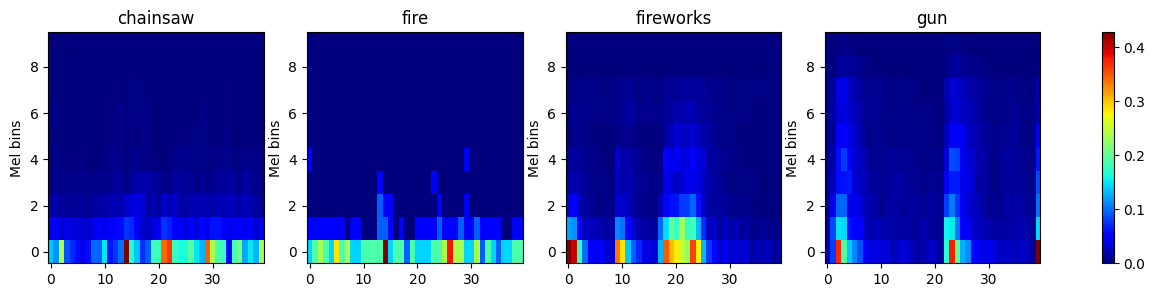

Test set
Number of elements in each class:  40
Number of sounds in dataset:  160


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


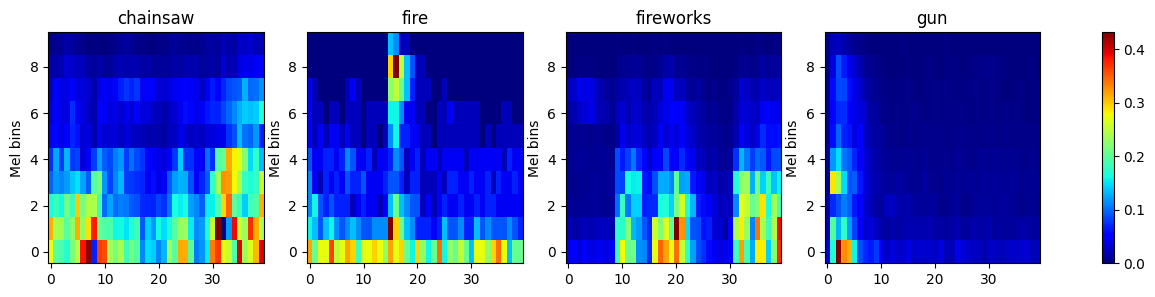

In [2]:
#Physical HP
#------------------------------------
Nft = 512
samples_per_melvec = Nft
n_melvec = 40
melvec_height = 10
window_type = "hamming" #hamming, hanning, blackman, rectangular, triangular
#Final sr: 7876.923076923076
sr = 7876.923076923076
#sr = 512 * n_melvec / 1.3
print("sr: ", sr)
flag_8bit = True #True
bit_sensitivity = 5 #0.1

#Visualisation
img_idx = 190
test_img_idx = 39

CNN_dataset = True

#HUGE CHANGE: trainset and testset are now obsolete:
#The train set is now totalset, without the background noise
#filter_str: only keeps the files that contain the filter_str
#The "physical_bg" noise now corresponds to the youtube sounds
#The test set is now the background noise

#TODO: When youtube sounds proved to be usedfull, modify Dataset class 
#so that they are taking into account in the time shift and add_bg
#------------------------------------

#1. Import classical  - #2. Train-test split
#--------------------------------
duration = n_melvec * Nft / sr 
print("Duration of each sample: ", duration, "s")


print("Train set")
#Does not take the background noise and youtube sounds into account
myds, dataset, classnames = get_dataset(path="../datasets/sounds/recorded_sounds/totalset_with_new/", filter_str=None,
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr, flag_8bit = flag_8bit, bit_sensitivity=bit_sensitivity,
    normalize=True, shift_pct=0, verbose=True, img_idx = img_idx, play_sound=True, CNN_dataset = CNN_dataset)

print("Test set")
myds_test, dataset_test, _ = get_dataset(path="../datasets/sounds/recorded_sounds/totalset_with_new/", filter_str="_background_", #"_background_",
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr,  flag_8bit = flag_8bit, bit_sensitivity=bit_sensitivity,
    normalize=True, shift_pct=0, verbose=True, img_idx = test_img_idx, play_sound=False, CNN_dataset = CNN_dataset)



In [ ]:
#3. Dataset augmentations
#----------------------------
#physical_bg is now physical_bg, name not changed inside the files

img_idx = 150
test_img_idx = 20
#CAREFUL: always respect the order
#augmentations = ["time_shift", "add_bg", "physical_bg"]
#augmentations = ["physical_bg"] #Physical bg is now youtube - TODO: correct the dataset code
augmentations = ["time_shift", "add_bg", "physical_bg"] #Physical bg is now youtube - TODO: correct the dataset code
shift_nb = 9                  if "time_shift" in augmentations else 0
bg_amplitude_limit = [0.1, 0.1, 0.316, 0.316] if "add_bg" in augmentations else []      #0.1: 20dB, 0.316: 5dB
physical_aug = ("physical_bg" in augmentations)

plot_indexes = [0,1,2,3,4,5,11,12,13,14,15] #indexes of the samples to plot
load_matrix = True

print("\nDataset Augmentations")
if "add_bg" in augmentations:
    bg_dataset = Dataset(folder="../datasets/sounds/recorded_sounds/background/", filter_str=None)
else :
    bg_dataset = None

if "physical_bg" in augmentations:
    my_phy_ds, phy_bg_dataset, classnames = get_dataset(path="../datasets/sounds/recorded_sounds/totalset_with_new/", filter_str="background",
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr,  flag_8bit = flag_8bit, bit_sensitivity=bit_sensitivity,
    normalize=True, shift_pct=0, verbose=False, img_idx = img_idx, play_sound=False, CNN_dataset = CNN_dataset)
else :
    my_phy_ds = None
    phy_bg_dataset = None


pickle_name = get_picklename( flag_8bit, bit_sensitivity,Nft,samples_per_melvec,n_melvec,melvec_height,window_type,sr,augmentations,shift_nb,bg_amplitude_limit,physical_aug,
    prefix="../datasets/melvecs/HP_tuning/",
    purpose = "melvecs" # "model"
)
if CNN_dataset:
    pickle_name+="_2D_"
print("pickle_name: ", pickle_name)

#---------------------------------

#Visualisation purposes
verbose = True
play_sound = True
print()
print("TRAIN SET")
X_train, y_train = augment_dataset(myds, dataset, classnames, augmentations, n_melvec = n_melvec, melvec_height=melvec_height,
                    shift_nb = shift_nb, #numbers of shifts done
                    bg_dataset = bg_dataset, bg_amplitude_limit=bg_amplitude_limit, #dataset used for background noise, background amplitudes
                    physical_bg_dataset = phy_bg_dataset,my_phy_ds = my_phy_ds, #dataset used for physical background noises
                    verbose=verbose, img_idx=img_idx, aug_indexes=plot_indexes, play_sound=play_sound, #verbose parameters
                    load_matrix=load_matrix, pickle_name=pickle_name, CNN_dataset=CNN_dataset) #load and save parameters


for class_idx, classname in enumerate(classnames):
    #print(classname, idx)
    featvec = myds[classname, 0]
    print(featvec.shape)
print("train shape: ", X_train[0].shape)
"""
TODO: ADD SHIFTS TO THE TEST SET
"""
print("TEST SET")
plot_indexes = [0,1]
verbose = True
play_sound = False

augmentations_test = ["time_shift"]
#augmentations_test = ["time_shift"] 
nb_shift_test = 2 if "time_shift" in augmentations_test else 0

pickle_name_test = get_picklename(
    flag_8bit, bit_sensitivity,Nft,samples_per_melvec,n_melvec,melvec_height,window_type,sr,augmentations_test,nb_shift_test,bg_amplitude_limit,physical_aug,
    prefix="../datasets/melvecs/HP_tuning/",
    purpose = "melvecs_test" # "model"
)
if CNN_dataset:
    pickle_name_test+="_2D_"
print("pickle_name_test: ", pickle_name_test)
load_matrix_test = True


X_test, y_test = augment_dataset(myds_test, dataset_test, classnames, augmentations = augmentations_test
                                 , n_melvec = n_melvec, melvec_height=melvec_height,
                                 
                shift_nb = nb_shift_test, #numbers of shifts done
                bg_dataset = None, bg_amplitude_limit=[], #dataset used for background noise, background amplitudes
                physical_bg_dataset = phy_bg_dataset,my_phy_ds = my_phy_ds, #dataset used for physical background noises
                verbose=verbose, img_idx=test_img_idx, aug_indexes=plot_indexes, play_sound=play_sound, #verbose parameters
               load_matrix=load_matrix_test, pickle_name=pickle_name_test, CNN_dataset=CNN_dataset) #load and save parameters

#Print shape of the test set
print("X_test shape: ", X_test.shape)

# Transform the labels to integers and save mapping
label_to_id = {label: i for i, label in enumerate(classnames)}
id_to_label = {i: label for label, i in label_to_id.items()}
y_train = np.array([label_to_id[label] for label in y_train])
y_test = np.array([label_to_id[label] for label in y_test])


#Shuffle X_train and y_train
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

#shuffle X_test and y_test
indices = np.arange(len(X_test))
np.random.shuffle(indices)
X_test = X_test[indices]
y_test = y_test[indices]


if CNN_dataset:
    # Identify invalid samples (all zeros or NaNs) across all dimensions except the first
    invalid_mask = np.any(np.isnan(X_train), axis=tuple(range(1, X_train.ndim))) | \
                np.all(X_train == 0, axis=tuple(range(1, X_train.ndim)))

    # Invert the mask to get valid entries
    valid_mask = ~invalid_mask

    # Filter X_train and y_train
    X_train = X_train[valid_mask]
    y_train = y_train[valid_mask]

    print(f"Removed {np.sum(invalid_mask)} invalid samples!")
    print(f"X_train shape after removing invalid samples: {X_train.shape}")
else:
    # Identify invalid samples (all zeros or NaNs)
    invalid_mask = np.any(np.isnan(X_train), axis=tuple(range(1, X_train.ndim))) | \
                np.all(X_train == 0, axis=tuple(range(1, X_train.ndim)))

    # Invert the mask to get valid entries
    valid_mask = ~invalid_mask

    # Filter X_train and y_train
    X_train = X_train[valid_mask]
    y_train = y_train[valid_mask]


    print(f"Removed {np.sum(invalid_mask)} invalid samples!")
    print(f"X_train shape after removing invalid samples: {X_train.shape}")
import matplotlib.pyplot as plt

i = 3
sample = X_train[i]
plt.imshow(
    sample.reshape((melvec_height, -1)), 
    cmap="jet",
    origin="lower",
    aspect="auto",
)
plt.colorbar()
plt.title(f"Sample {i} - Class {y_train[i]}")
plt.show()


Dataset Augmentations
pickle_name:  ../datasets/melvecs/HP_tuning/melvecs_int8s5_512_512_40_10_hamming_7876_time_shift_9_add_bg_4_physical_bg_2D_

TRAIN SET
File ../datasets/melvecs/HP_tuning/melvecs_int8s5_512_512_40_10_hamming_7876_time_shift_9_add_bg_4_physical_bg_2D_ not found. Generating new dataset.
Number of shifts:  9
Number of bg_amplitude_limit and values:  4 [0.1, 0.1, 0.316, 0.316]
Physical augmentation:  True
X_aug shape:  (11360, 10, 40)


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/classification/src/classification/Q2/mcu_emulation_v2_1.py:90: RuntimeWarning: divide by zero encountered in scalar floor_divide
  buf[i] = ((np.int32(buf_fft[i]) << (num_bits-1)) // np.int32(vmax)).astype(np.int16)


Augmenting with time_shift
Shift number:  1
Shift percentage:  0.1312263890373233
0/200
1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/

### 5. Modelling

In [4]:
import traceback
#CNN architecture
#----------------------------------------------

#Tuner
epochs = 50
epochs_tuner = 10
validation_split = 0.2
patience = 8
batch_size = 32
#TODO: optimal batch size to find

#A. HyperResNet
hyperResNet = HyperResNet(input_shape=X_train.shape[1:], classes=4)

#B. HyperEfficientNet
hyperEfficientNet = HyperEfficientNet(input_shape=X_train.shape[1:], classes=4)

#C. HyperXception
hyperXception = HyperXception(input_shape=X_train.shape[1:], classes=4)


if CNN_dataset:
    def self_made_builder_factory(input_shape):
        def self_made_builder(hp):
            try:
                model = tf.keras.Sequential()
                model.add(tf.keras.Input(shape=input_shape))  # Ensure this is (height, width, channels)
                model.add(tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1)))

                num_conv_layers = hp.Int("num_conv_layers", 0, 3)

                for i in range(num_conv_layers):
                    kernel_size = hp.Choice(f"kernel_size_{i}", values=[3, 5, 7, 9])
                    pool_size = hp.Choice(f"pool_size_{i}", values=[2, 3, 4])

                    model.add(
                        tf.keras.layers.Conv2D(
                            filters=hp.Int(f"filters_{i}", min_value=16, max_value=256, step=16),
                            kernel_size=(kernel_size, kernel_size),
                            activation=hp.Choice(f"activation_conv_{i}", values=['relu', 'tanh', 'sigmoid']),
                        )
                    )
                    model.add(tf.keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size)))
                    model.add(tf.keras.layers.BatchNormalization())
                
                # After convolutional layers, flatten the output to feed into dense layers
                model.add(tf.keras.layers.Flatten())

                # Dense layers
                for i in range(hp.Int("num_dense_layers", 0, 3)):  # Flexible Dense layers
                    model.add(
                        tf.keras.layers.Dense(
                            units=hp.Int(f"dense_layer_{i}", min_value=32, max_value=256, step=32),
                            activation=hp.Choice('activation_dense_{i}', values=['relu', 'tanh', 'sigmoid']),
                            kernel_regularizer=tf.keras.regularizers.l2(hp.Choice("l2_reg", values=[0.0, 0.001, 0.01, 0.05, 0.1]))
                        )
                    )
                    model.add(tf.keras.layers.Dropout(rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.6, step=0.1)))

                model.add(tf.keras.layers.Dense(4, activation='softmax'))

                # Learning rate and optimizer
                hp_learning_rate = hp.Choice('learning_rate', values=[0.5e-1,1e-2, 1e-3, 1e-4])
                opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

                model.compile(optimizer=opt,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
                return model
            except Exception as e:
                print("\n[ERROR] Model creation failed.")
                print(f"Reason: {e}")
                print("Full traceback:")
                traceback.print_exc()

                # Create a terrible dummy model to ensure very low accuracy
                bad_model = tf.keras.Sequential([
                    tf.keras.Input(shape=input_shape),
                    tf.keras.layers.Lambda(lambda x: tf.zeros_like(x)),  # Kills all features
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(4, activation='softmax',
                                        kernel_initializer='zeros',
                                        bias_initializer='zeros')
                ])
                bad_model.compile(
                    optimizer='sgd',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )
                return bad_model
        return self_made_builder
else:      
    #D. Self-made 1
    def self_made_builder_factory(input_shape):
        #Enable to pass input_shape to the function
        def self_made_builder(hp):
            
            model = tf.keras.Sequential()
            model.add(tf.keras.Input(shape = input_shape))
            model.add(tf.keras.layers.Flatten())

            hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])

            for i in range(hp.Int("num_layers", 1,5)):
                model.add(
                    tf.keras.layers.Dense(
                        # Tune number of units separately.
                        units=hp.Int(f"layer_{i}", min_value=1, max_value=526, step=32),
                        activation=hp_activation,
                    )
                )
                ## Add dropout after each dense layer
                model.add(
                    tf.keras.layers.Dropout(
                        rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)
                    )
                )
            #hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=512, step=32)
            #hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=512, step=32)
            hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 

            #model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
            #model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
            model.add(tf.keras.layers.Dense(4, activation='softmax'))

            opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

            model.compile(optimizer=opt,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

            return model
        return self_made_builder

if CNN_dataset:
    project_name = "basic_ref_model_2D_20melvecs_time_shift14_corrected"
else:
    project_name = "basic_ref_model_20"
    #project_name = "test_opti"


def create_tuner(hypermodel):
    return kt.Hyperband(hypermodel,
                    objective='val_accuracy',
                    max_epochs=epochs_tuner,
                    factor=3,
                    directory='hp_dir',
                    project_name=project_name,
                    overwrite= True)
"""
basic_ref_model
Hyperparameters:
activation: relu
num_layers: 1
layer_0: 256
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.7013888955116272
Kfold: 82
Test: 58
"""

# Add a channel dimension (grayscale images or 1-channel features)
#X_train = X_train[..., np.newaxis]
#X_test = X_test[..., np.newaxis]

#print(X_train[1].shape)

#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=4)
#(A: HyperResNet, B: HyperEfficientNet, C: HyperXception, D: self_made_builder)
#input_shape = X_train.shape[1:]
#input_shape = X_train[0].shape


input_shape = X_train[0].shape 
print("input shape: ", input_shape)

builder = self_made_builder_factory(input_shape)
tuner = create_tuner(builder)
'''
# Create the HyperResNet model
hypermodel = HyperResNet(input_shape=input_shape, classes=4)

# Create the tuner
tuner = kt.Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=epochs_tuner,
    factor=3,
    directory='hp_dir',
    project_name='hyperresnet',
    overwrite=True
)
'''

# Create an hp object to pass batch size
#hp = kt.HyperParameters()
#batch_size = hp.Choice('batch_size', values=[32,64,128])
print("batch size: ", batch_size)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

# Run tuner search
tuner.search(
    X_train, y_train,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=[stop_early],
    batch_size=batch_size
)

tuner.results_summary()


Trial 28 Complete [00h 04m 32s]
val_accuracy: 0.6575704216957092

Best val_accuracy So Far: 0.8252640962600708
Total elapsed time: 00h 25m 05s
Results summary
Results in hp_dir/basic_ref_model_2D_20melvecs_time_shift14_corrected
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0015 summary
Hyperparameters:
num_conv_layers: 1
num_dense_layers: 1
learning_rate: 0.001
kernel_size_0: 5
pool_size_0: 3
filters_0: 48
activation_conv_0: relu
kernel_size_1: 5
pool_size_1: 2
filters_1: 64
activation_conv_1: sigmoid
kernel_size_2: 5
pool_size_2: 2
filters_2: 16
activation_conv_2: sigmoid
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
dense_layer_0: 32
activation_dense_{i}: relu
l2_reg: 0.0
dropout_rate_0: 0.1
tuner/trial_id: 0012
dense_layer_1: 128
dropout_rate_1: 0.4
dense_layer_2: 224
dropout_rate_2: 0.5
Score: 0.8252640962600708

Trial 0012 summary
Hyperparameters:
num_conv_layers: 1
num_dense_layers: 1
learning_rate: 0.001
kernel_size_0: 5

### 6. Training

In [5]:

#5. Final model
validation_split = 0.2
final_epochs = 25
final_patience = 10
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=final_patience, restore_best_weights=True)


model_name = get_picklename(
    flag_8bit, bit_sensitivity,Nft,samples_per_melvec,n_melvec,melvec_height,window_type,sr,augmentations,shift_nb,
    bg_amplitude_limit,physical_aug,
    prefix="../datasets/models/",
    purpose = "model"
)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print("Best hyperparameters: ", best_hps.values)

#top_trials = tuner.get_best_hyperparameters(num_trials=2)
#best_hps = top_trials[1]  # index 1 is second-best
#print("Best hyperparameters: ", best_hps.values)


#Temporary model to find the best number of epochs - avoid overfitting
temp_model = tuner.hypermodel.build(best_hps)
history = temp_model.fit(X_train, y_train, epochs=final_epochs, validation_split=validation_split, callbacks=[stop_early])
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best hyperparameters:  {'num_conv_layers': 1, 'num_dense_layers': 1, 'learning_rate': 0.001, 'kernel_size_0': 5, 'pool_size_0': 3, 'filters_0': 48, 'activation_conv_0': 'relu', 'kernel_size_1': 5, 'pool_size_1': 2, 'filters_1': 64, 'activation_conv_1': 'sigmoid', 'kernel_size_2': 5, 'pool_size_2': 2, 'filters_2': 16, 'activation_conv_2': 'sigmoid', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'dense_layer_0': 32, 'activation_dense_{i}': 'relu', 'l2_reg': 0.0, 'dropout_rate_0': 0.1, 'tuner/trial_id': '0012', 'dense_layer_1': 128, 'dropout_rate_1': 0.4, 'dense_layer_2': 224, 'dropout_rate_2': 0.5}
Epoch 1/25
284/284 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.5205 - loss: 1.1020 - val_accuracy: 0.4428 - val_loss: 1.2211
Epoch 2/25
284/284 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.7165 - loss: 0.7358 - val_accuracy: 0.7548 - val_loss: 0.7708
Epoch 3/25
284/284 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.7553 - loss: 0.6466 - val_accu

### 8. Final model evaluation

Epoch 1/21
284/284 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.5217 - loss: 1.0976 - val_accuracy: 0.6342 - val_loss: 1.1895
Epoch 2/21
284/284 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.7091 - loss: 0.7552 - val_accuracy: 0.6849 - val_loss: 0.8393
Epoch 3/21
284/284 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.7588 - loss: 0.6368 - val_accuracy: 0.7707 - val_loss: 0.5985
Epoch 4/21
284/284 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7771 - loss: 0.5735 - val_accuracy: 0.7645 - val_loss: 0.6025
Epoch 5/21
284/284 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.8029 - loss: 0.5215 - val_accuracy: 0.7808 - val_loss: 0.5978
Epoch 6/21
284/284 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.8173 - loss: 0.4819 - val_accuracy: 0.8090 - val_loss: 0.5048
Epoch 7/21
284/284 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.8258 - loss: 0.4732 - val_accuracy: 0.8041 - val_loss: 0.5118
Epoch 8/21
284/284 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.8295 - loss: 0.4417 - 

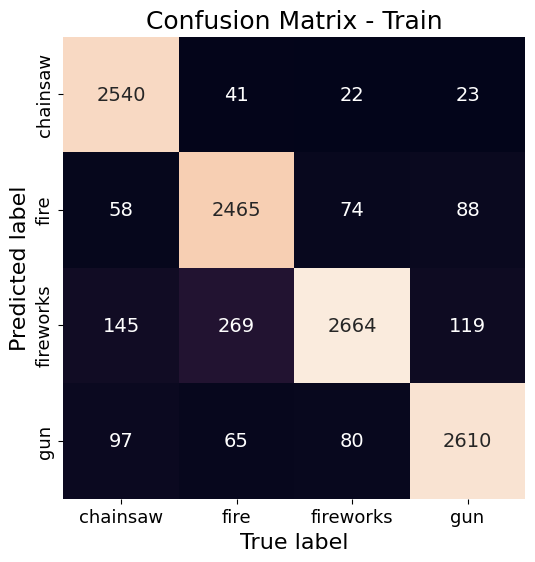


Classification Report - Train:
              precision    recall  f1-score   support

    chainsaw       0.97      0.89      0.93      2840
        fire       0.92      0.87      0.89      2840
   fireworks       0.83      0.94      0.88      2840
         gun       0.92      0.92      0.92      2840

    accuracy                           0.90     11360
   macro avg       0.91      0.90      0.91     11360
weighted avg       0.91      0.90      0.91     11360

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Accuracy on test set: 0.91875


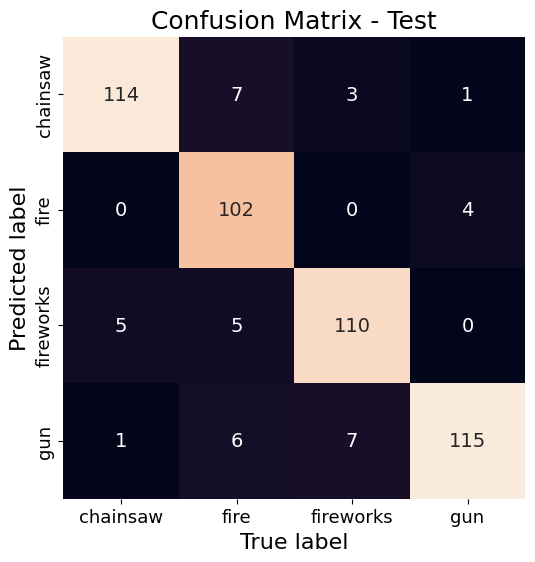


Classification Report - Test:
              precision    recall  f1-score   support

    chainsaw       0.91      0.95      0.93       120
        fire       0.96      0.85      0.90       120
   fireworks       0.92      0.92      0.92       120
         gun       0.89      0.96      0.92       120

    accuracy                           0.92       480
   macro avg       0.92      0.92      0.92       480
weighted avg       0.92      0.92      0.92       480

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9173 - loss: 0.3718
[test loss, test accuracy]: [0.3744349777698517, 0.918749988079071]
Saving model to:  ../datasets/models/model_int8s5_512_512_20_10_hamming_7876_time_shift_9_add_bg_4_physical_bgCNN_20melvecs_background_train_76_test_92


[01:26:19] WARNING  You are saving your model as an HDF5 file via `model.save()` or                ]8;id=310796;file:///home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py\saving_api.py]8;;\:]8;id=955118;file:///home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py#83\83]8;;\
                    `keras.saving.save_model(model)`. This file format is considered legacy. We                    
                    recommend using instead the native Keras format, e.g.                                          
                    `model.save('my_model.keras')` or `keras.saving.save_model(model,                              
                    'my_model.keras')`.                                                                            

In [6]:
#Final results
#------------------------------

if y_train.ndim > 1:
    y_train = np.argmax(y_train, axis=1)
if y_test is not None and y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)


#Remove tensorflow warnings
tf.data.experimental.enable_debug_mode()

#Train the model with the best hyperparameters and best epoch
hypermodel = tuner.hypermodel.build(best_hps)
hp_learning_rate = best_hps.get('learning_rate')
opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
hypermodel.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=validation_split) #validation_split=validation_split)
k = 5

save_model = True

#Clone the model for k-fold
kfold_model = tf.keras.models.clone_model(hypermodel)
#Get the best tuning rate from the best hyperparameters
hp_learning_rate = best_hps.get('learning_rate')
opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
kfold_model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

epochs_kfold = best_epoch // 5

 # Make sure to recompile
# Train of the model & evaluation -  K-Fold cross-validation
kfold_acc, kfold_recall, kfold_f1 = perform_kfold(kfold_model, X_train, y_train, k=k, epochs=epochs_kfold)


#Train- Test evaluation
train_confmat, train_report, test_accuracy, test_confmat, test_report= evaluate_model(hypermodel, 
                        X_train, y_train, classnames, X_test, y_test,show_confusion=True)


if (X_test is not None):
    predictions = hypermodel.predict(X_test)
    eval_result = hypermodel.evaluate(X_test, y_test)
    print("[test loss, test accuracy]:", eval_result)

    
if save_model:
    model_name = get_picklename(
        flag_8bit, bit_sensitivity,        
        Nft,
        samples_per_melvec,
        n_melvec,
        melvec_height,
        window_type,
        sr,
        augmentations,
        shift_nb,
        bg_amplitude_limit,
        physical_aug,
        prefix="../datasets/models/",
        purpose = "model"
    )
    model_name += "CNN_20melvecs_background" 
    #Add _train_{kfold_acc}_test_{test_accuracy} to the name
    model_name += "_train_{:.0f}_test_{:.0f}".format(np.mean(kfold_acc*100), test_accuracy*100)

    #Check if the model already exists
    if os.path.exists(model_name + ".h5"):
        print("Model already exists!!")
        model_name = model_name + "_new"
    print("Saving model to: ", model_name)
    hypermodel.save(model_name + ".h5")


In [7]:
img_idx])
#print the sample:
print(sample)
i = 3
sample = X_train[i]
plt.imshow(
    sample.reshape((melvec_height, -1)), 
    cmap="jet",
    origin="lower",
    aspect="auto",
)
plt.colorbar()
plt.title(f"Sample {i} - Class {y_train[i]}")
plt.show()
#Plot the sample
import matplotlib.pyplot as plt
plt.imshow(
    sample.reshape((n_melvec, melvec_height)).T, 
    cmap="jet",
    origin="lower",
    aspect="auto",
)
plt.draw()
plt.pause(0.1)
plt.clf()

#Plot the sample of (20,10) with an other way
sample = sample.reshape((n_melvec, melvec_height)).T
plt.imshow(sample, aspect='auto', cmap='viridis')
plt.title(f"Sample {img_idx} - Label: {y_train[img_idx]}")
plt.colorbar()
plt.xlabel("Mel vector")
plt.ylabel("Time")
plt.show()

#Third way
#Transform
plt.imshow(
    sample.reshape((melvec_height, -1)), 
    cmap="jet",
    origin="lower",
    aspect="auto",
)
#plt.set_xlabel("")
#plt.set_ylabel("Mel bins")

'''
#Remove tensorflow warnings
tf.data.experimental.enable_debug_mode()

#Train the model with the best hyperparameters and best epoch
hypermodel = tuner.hypermodel.build(best_hps)
hp_learning_rate = best_hps.get('learning_rate')
opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
hypermodel.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=validation_split) #validation_split=validation_split)
k = 5

save_model = True

#Clone the model for k-fold
kfold_model = tf.keras.models.clone_model(hypermodel)
#Get the best tuning rate from the best hyperparameters
hp_learning_rate = best_hps.get('learning_rate')
opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
kfold_model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

epochs_kfold = best_epoch // 5

 # Make sure to recompile
# Train of the model & evaluation -  K-Fold cross-validation
kfold_acc, kfold_recall, kfold_f1 = perform_kfold(kfold_model, X_train, y_train, k=k, epochs=epochs_kfold)


#Train- Test evaluation
train_confmat, train_report, test_accuracy, test_confmat, test_report= evaluate_model(hypermodel, 
                        X_train, y_train, classnames, X_test, y_test,show_confusion=True)


if (X_test is not None):
    predictions = hypermodel.predict(X_test)
    eval_result = hypermodel.evaluate(X_test, y_test)
    print("[test loss, test accuracy]:", eval_result)

    
if save_model:
    model_name = get_picklename(
        flag_8bit, bit_sensitivity,        
        Nft,
        samples_per_melvec,
        n_melvec,
        melvec_height,
        window_type,
        sr,
        augmentations,
        shift_nb,
        bg_amplitude_limit,
        physical_aug,
        prefix="../datasets/models/",
        purpose = "model"
    )
    model_name += "CNN_20melvecs_corrected_middletrained" 
    #Add _train_{kfold_acc}_test_{test_accuracy} to the name
    model_name += "_train_{:.0f}_test_{:.0f}".format(np.mean(kfold_acc*100), test_accuracy*100)

    #Check if the model already exists
    if os.path.exists(model_name + ".h5"):
        print("Model already exists!!")
        model_name = model_name + "_new"
    print("Saving model to: ", model_name)
    hypermodel.save(model_name + ".h5")
'''

SyntaxError: unmatched ']' (991804197.py, line 1)

In [18]:
def plot_specgram(
    specgram,
    ax,
    is_mel=False,
    title=None,
    xlabel="Time [s]",
    ylabel="Frequency [Hz]",
    textlabel = "",
    cmap="jet",
    cb=True,
    tf=None,
    invert=True,
):
    """
    Plot a spectrogram (2D matrix) in a chosen axis of a figure.
    Inputs:
        - specgram = spectrogram (2D array)
        - ax       = current axis in figure
        - title
        - xlabel
        - ylabel
        - cmap
        - cb       = show colorbar if True
        - tf       = final time in xaxis of specgram
    """
    if tf is None:
        tf = specgram.shape[1]

    if is_mel:
        ylabel = "Frequency [Mel]"
        im = ax.imshow(
            specgram, cmap=cmap, aspect="auto", extent=[0, tf, specgram.shape[0], 0]
        )
    else:
        im = ax.imshow(
            specgram,
            cmap=cmap,
            aspect="auto",
            extent=[0, tf, int(specgram.size / tf), 0],
        )
    if invert:
        ax.invert_yaxis()
    fig = plt.gcf()
    if cb:
        fig.colorbar(im, ax=ax)
    # cbar.set_label('log scale', rotation=270)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    plt.subplots_adjust(bottom=0.3)
    ax.text(0, -0.15, f'{textlabel}', ha='left', va='top', transform=ax.transAxes, family='monospace')

    return None
